In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import time
from sklearn.preprocessing import MinMaxScaler
minmax= MinMaxScaler()

images = np.load("images.npy")
labels = np.load("labels.npy")
HEIGHT = images.shape[1]
WIDTH = images.shape[2]
ELEMENT = HEIGHT*WIDTH

# images_processed = minmax.fit_transform(images.reshape(images.shape[0], ELEMENT))
images_reshaped = images.reshape(images.shape[0], 1, HEIGHT,WIDTH)
# images_reshaped = images.reshape(images.shape[0], 1, HEIGHT,WIDTH)
# images_normed =  (images_reshaped - np.mean(images_reshaped, axis = 0))/np.std(images_reshaped, axis = 0)


NUM_IMAGES =  images_reshaped.shape[0]# number of images
NUM_VAL_IMAGES = NUM_IMAGES // 100
NUM_TRAIN_IMGAGES = NUM_IMAGES - NUM_VAL_IMAGES


indices = np.random.permutation(images_reshaped.shape[0])
training_idx, test_idx = indices[:NUM_TRAIN_IMGAGES], indices[NUM_TRAIN_IMGAGES:]
training_image, test_image = images_reshaped[training_idx,:], images_reshaped[test_idx,:]
training_label = labels[training_idx]
test_label = labels[test_idx]
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
              # 3x3 convolution that takes in an image with one channel
              # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3)
              # 3x3 convolution that takes in an image with 8 channels
              # and outputs an image with 16 channels. The output image
              # has approximately half the height and half the width
              # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2)
              # 1x1 convolution that takes in an image with 16 channels and
              # produces an image with 5 channels. Here, the 5 channels
              # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(16, 5, kernel_size=1)
    def forward(self, x):
              # Convolutions work with images of shape
              # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
  

        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
    
def approx_train_accuracy(y_hat, labels):
    labels = labels.detach().numpy()
    y_hat = y_hat.detach().numpy()

    return np.sum(y_hat==labels)/float(labels.size)

def train(batch_size, train_seqs, train_labels):
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = torch.from_numpy(train_seqs[i].astype(np.float32))
    y = torch.from_numpy(train_labels[i].astype(np.int))
    # Forward pass: Compute predicted y by passing x to the model
    y_hat_ = model(x)
    
    # Compute and print loss
    loss = F.cross_entropy(y_hat_, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()
    
model = TooSimpleConvNN()


# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

NUM_OPT_STEPS = 2000
batch_size = 150

# # ELEMENTS = images_reshaped.shape[1]# length of the image vector 
D_H = 100 # numbers of hidden layers 
NUM_CLASSES = 5 # number of classes
index_store = []
train_accs, val_accs = [], []
val_correct = []
# total = []
images_val = test_image
labels_val = test_label
start = time.time()
for i in range(NUM_OPT_STEPS):
#     scheduler.step()
    loss = train(batch_size,training_image,training_label )

    if i % 100 == 0:
        radom_index = np.random.choice(training_image.shape[0], size= 1000, replace=False)
        x_acc = torch.from_numpy(training_image[radom_index].astype(np.float32))
        y_acc = torch.from_numpy(training_label[radom_index].astype(np.int))

        y_hat_acc = model(x_acc)
        _, y_pred = torch.max(y_hat_acc,1)
        accuracy = np.sum((y_pred==y_acc).detach().numpy())/(y_acc.size())
        train_accs.append(accuracy*100)
        index_store.append(i)

        with torch.no_grad():


            val_correct = []
            for j in range(labels_val.shape[0]):
                x_val = torch.from_numpy(images_val[j].astype(np.float32))
                outputs = model(x_val)
                predicted = torch.max(outputs, 1)[1]
                val_correct.append((predicted.item() == labels_val[j]).sum().item())
           
            total = len(labels_val)
            val_accs.append((np.sum(val_correct) / total) * 100)
            val_ac = (np.sum(val_correct) / total) * 100
        print("Training Accyracy: ",accuracy*100, "validation accuracy: ",val_ac )

end = time.time()
print(end - start)



Training Accyracy:  [19.5] validation accuracy:  17.8
Training Accyracy:  [42.7] validation accuracy:  43.6
Training Accyracy:  [53.2] validation accuracy:  54.2
Training Accyracy:  [60.6] validation accuracy:  57.99999999999999
Training Accyracy:  [66.7] validation accuracy:  68.0
Training Accyracy:  [67.5] validation accuracy:  68.60000000000001
Training Accyracy:  [73.2] validation accuracy:  71.39999999999999
Training Accyracy:  [70.7] validation accuracy:  68.0
Training Accyracy:  [74.] validation accuracy:  71.39999999999999
Training Accyracy:  [75.5] validation accuracy:  74.6
Training Accyracy:  [72.7] validation accuracy:  73.6
Training Accyracy:  [73.6] validation accuracy:  77.0
Training Accyracy:  [76.1] validation accuracy:  74.8
Training Accyracy:  [77.5] validation accuracy:  74.8
Training Accyracy:  [77.5] validation accuracy:  75.8
Training Accyracy:  [78.3] validation accuracy:  74.4
Training Accyracy:  [80.5] validation accuracy:  77.2
Training Accyracy:  [76.5] vali

Text(0, 0.5, 'Accuracy %')

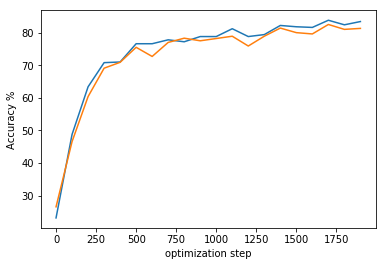

In [9]:
plt.plot(index_store, val_accs, index_store, train_accs)

plt.xlabel("optimization step")
plt.ylabel("Accuracy %")

In [8]:
# Test the model
model.eval()
with torch.no_grad():
    correct = []
    total = []
    images_val = test_image
    labels_val = test_label
    
    for i in range(labels_val.shape[0]):
        x_val = torch.from_numpy(images_val[i].astype(np.float32))
#         labels_val = torch.from_numpy(labels_val.astype(np.int))

        outputs = model(x_val)
        predicted = torch.max(outputs, 1)[1]
        total = labels_val.size
        correct.append((predicted.item() == labels_val[i]).sum().item())
    total = len(labels_val)
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((np.sum(correct) / total) * 100))


Test Accuracy of the model on the 10000 test images: 82.8 %
